# Delta Hedging

### The Black and Scholes Risk Neutral Portfolio : $\Pi = V - \Delta S$
### V value of the option, S the underlying

# Defining a few functions

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd

# Function to simulate stock price path
def simulate_stock_price(S0, T, r, sigma, N):
    dt = T / N
    price_path = [S0]
    for _ in range(1, N + 1):
        z = np.random.standard_normal()  # Random draw from standard normal distribution
        S_t = price_path[-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
        price_path.append(S_t)
    return np.array(price_path)

# Black-Scholes formula for European call option price
def bs_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / ((sigma * np.sqrt(T))+0.00000001) #+0.00000001 for no dividing by 0
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Delta of a European call option
def delta_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / ((sigma * np.sqrt(T))+0.00000001) #+0.00000001 for no dividing by 0
    delta = norm.cdf(d1)
    return delta

# Initial parameters
S0 = 100  # Initial stock price
K = 100   # Strike price
T = 1     # Time to maturity in years
r = 0.039  # Risk-free rate
sigma = 0.2 # Volatility
N = 252   # Number of steps (trading days in a year)

# discrete hedging (no rebalancing)

In [62]:
stock_path = simulate_stock_price(S0, T, r, sigma, N)


df = pd.DataFrame(stock_path)
df = df.reset_index()
df.columns = ['time', 'St']
df["ttm"] =  - df["time"]/252 + T
df['delta'] = df.apply(lambda row: delta_call(row['St'], K, row['ttm'], r, sigma), axis=1)
df['Call_Price'] = df.apply(lambda row: bs_call_price(row['St'], K, row['ttm'], r, sigma), axis=1)

delta_init = df.iloc[0]["delta"]
delta_S0 = delta_init * 100

df["St_rets"] = df["St"].pct_change()+1


df["delta_St"] = 0

df.loc[0, "delta_St"] = delta_S0
for i in range(1, len(df)):
    df.loc[i, "delta_St"] = df.loc[i-1, "delta_St"] * df.loc[i, "St_rets"]

df["risk_neutral_portfolio"] = df["delta_St"] + df["Call_Price"]
df

,time,St,ttm,delta,Call_Price,St_rets,delta_St,risk_neutral_portfolio
0,0,100.000000,1.000000,0.636831,10.450584,NaN,63.683059,74.133642
1,1,101.003754,0.996032,0.655179,11.073458,1.010038,64.322280,75.395738
2,2,102.844102,0.992063,0.687717,12.283504,1.018221,65.494270,77.777774
3,3,101.606428,0.988095,0.665701,11.419844,0.987966,64.706081,76.125925
4,4,102.263607,0.984127,0.677252,11.835137,1.006468,65.124593,76.959730
...,...,...,...,...,...,...,...,...
248,248,110.017981,0.015873,0.999937,10.097356,1.005226,70.062815,80.160171
249,249,111.667682,0.011905,1.000000,11.727188,1.014995,71.113395,82.840584
250,250,111.067292,0.007937,1.000000,11.106967,0.994623,70.731049,81.838015
251,251,113.183844,0.003968,1.000000,13.203683,1.019056,72.078934,85.282617


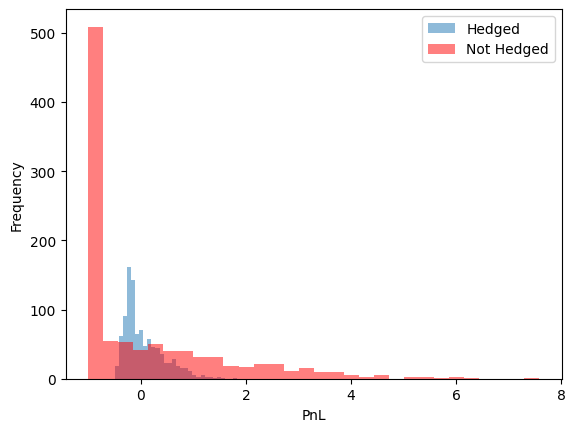

hedged portfolio mean : 0    0.047421
dtype: float64 std 0    0.37827
dtype: float64
not hedged portfolio mean : 0    0.039421
dtype: float64 std 0    1.45044
dtype: float64


In [12]:
"""
hedged vs not hedged
"""
vals = []
unhedged_vals = []

for i in range(1,1000) :
  stock_path = simulate_stock_price(S0, T, r, sigma, N)

  df = pd.DataFrame(stock_path)
  df = df.reset_index()
  df.columns = ['time', 'St']
  df["ttm"] =  - df["time"]/252 + T
  df['delta'] = df.apply(lambda row: delta_call(row['St'], K, row['ttm'], r, sigma), axis=1)
  df['Call_Price'] = df.apply(lambda row: bs_call_price(row['St'], K, row['ttm'], r, sigma), axis=1)

  #for initially hedged pf
  delta_init = df.iloc[0]["delta"]
  delta_S0 = delta_init * 100
  df["St_rets"] = df["St"].pct_change()+1
  df["delta_St"] = 0
  df.loc[0, "delta_St"] = delta_S0
  for i in range(1, len(df)):
      df.loc[i, "delta_St"] = df.loc[i-1, "delta_St"] * df.loc[i, "St_rets"]
  df["risk_neutral_portfolio"] = df["delta_St"] + df["Call_Price"]
  val = (df.iloc[-1]["risk_neutral_portfolio"] - df.iloc[0]["risk_neutral_portfolio"]) / df.iloc[0]["risk_neutral_portfolio"]
  vals.append(val)

  #for unhedged pf
  unhedged_val = (max(df.iloc[-1]["St"]-K,0) - df.iloc[0]["Call_Price"]) / df.iloc[0]["Call_Price"]
  unhedged_vals.append(unhedged_val)

x = pd.DataFrame(vals)
y = pd.DataFrame(unhedged_vals)

plt.hist(x, bins=30, alpha=0.5, label="Hedged")
plt.hist(y, bins=30, alpha=0.5, color='red', label="Not Hedged")
plt.xlabel('PnL')
plt.ylabel('Frequency')
plt.legend()
plt.show()


print('hedged portfolio mean :', round(x.mean(),3), "std", round(x.std(),3))
print('not hedged portfolio mean :', round(y.mean(),3), "std", round(y.std(),3))


# Rebalancing every 21 days (dynamic Hedging)


In [107]:
import numpy as np
import pandas as pd

# Assuming simulate_stock_price, delta_call, and bs_call_price are defined elsewhere
# And assuming S0, T, r, sigma, N, K are defined

stock_path = simulate_stock_price(S0, T, r, sigma, N)

df = pd.DataFrame(stock_path)
df = df.reset_index()
df.columns = ['time', 'St']
df["ttm"] = -df["time"] / 252 + T
df['delta'] = df.apply(lambda row: delta_call(row['St'], K, row['ttm'], r, sigma), axis=1)
df['Call_Price'] = df.apply(lambda row: bs_call_price(row['St'], K, row['ttm'], r, sigma), axis=1)

delta_init = df.iloc[0]["delta"]
delta_S0 = delta_init * S0
df["St_rets"] = df["St"].pct_change().fillna(0) + 1
df["delta_St"] = 0
df.loc[0, "delta_St"] = delta_S0

# Initialize a column for PnL tracking
df["PnL"] = 0.0

# Track cash flow from rebalancing and initial option purchase (negative for buying options)
cash_flow = -df.loc[0, "Call_Price"]  # Assuming buying one option for simplicity

for i in range(1, len(df)):
    if i % 21 == 0:  # Rebalance every 7 days
        shares_to_buy = df.loc[i, "delta"] * 100 - df.loc[i - 1, "delta_St"]  # Assuming 100 options for simplicity
        cash_flow -= shares_to_buy * df.loc[i, "St"]  # Adjust cash flow based on rebalancing cost
        df.loc[i, "delta_St"] = df.loc[i, "delta"] * 100  # Update delta position
    else:
        df.loc[i, "delta_St"] = df.loc[i - 1, "delta_St"]  # Carry forward the delta position for non-rebalancing days

    # Update PnL for the hedging position
    df.loc[i, "PnL"] = cash_flow + df.loc[i, "delta_St"] * df.loc[i, "St"] + df.loc[i, "Call_Price"] * 100  # Assuming selling the option at current price
PnL_ret = (df.loc[252, "PnL"] - df.loc[1, "PnL"]) / df.loc[1, "PnL"]
# Note: This example simplifies several aspects for clarity, such as ignoring transaction costs and assuming a single option.
PnL_ret

0.057824365695227094

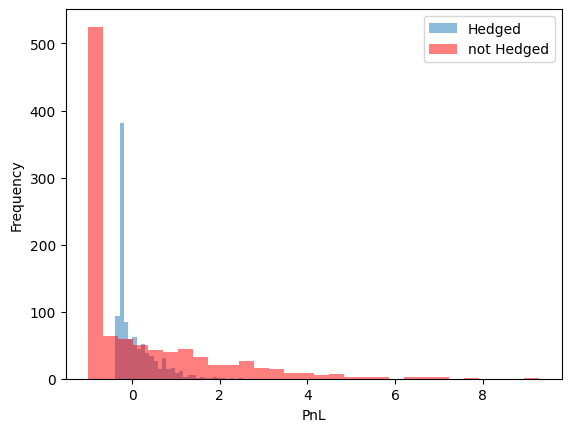

hedged portfolio mean : 0.0533231791761857 std 0.44359064580874363
not hedged portfolio mean : 0.08475725009485517 std 1.5817297894331392


In [18]:
"""
hedged vs not hedged
"""
vals = []
unhedged_vals = []

for i in range(1,1000) :
  stock_path = simulate_stock_price(S0, T, r, sigma, N)

  df = pd.DataFrame(stock_path)
  df = df.reset_index()
  df.columns = ['time', 'St']
  df["ttm"] = -df["time"] / 252 + T
  df['delta'] = df.apply(lambda row: delta_call(row['St'], K, row['ttm'], r, sigma), axis=1)
  df['Call_Price'] = df.apply(lambda row: bs_call_price(row['St'], K, row['ttm'], r, sigma), axis=1)

  delta_init = df.iloc[0]["delta"]
  delta_S0 = delta_init * S0
  df["St_rets"] = df["St"].pct_change().fillna(0) + 1
  df["delta_St"] = 0
  df.loc[0, "delta_St"] = delta_S0

  # Initialize a column for PnL tracking
  df["PnL"] = 0.0

  # Track cash flow from rebalancing and initial option purchase (negative for buying options)
  cash_flow = -df.loc[0, "Call_Price"]  # Assuming buying one option for simplicity

  for i in range(1, len(df)):
      if i % 21 == 0:  # Rebalance every 21 days
          shares_to_buy = df.loc[i, "delta"] * 100 - df.loc[i - 1, "delta_St"]  # Assuming 100 options for simplicity
          cash_flow -= shares_to_buy * df.loc[i, "St"]  # Adjust cash flow based on rebalancing cost
          df.loc[i, "delta_St"] = df.loc[i, "delta"] * 100  # Update delta position
      else:
          df.loc[i, "delta_St"] = df.loc[i - 1, "delta_St"]  # Carry forward the delta position for non-rebalancing days

      # Update PnL for the hedging position
      df.loc[i, "PnL"] = cash_flow + df.loc[i, "delta_St"] * df.loc[i, "St"] + df.loc[i, "Call_Price"] * 100  # Assuming selling the option at current price

  PnL_ret = (df.loc[252, "PnL"] - df.loc[1, "PnL"]) / df.loc[1, "PnL"]

  val = PnL_ret
  vals.append(val)

  #for unhedged pf
  unhedged_val = (max(df.iloc[-1]["St"]-K,0) - df.iloc[0]["Call_Price"]) / df.iloc[0]["Call_Price"]
  unhedged_vals.append(unhedged_val)

x = pd.DataFrame(vals)
y = pd.DataFrame(unhedged_vals)

plt.hist(x, bins=30, alpha=0.5, label="Hedged")
plt.hist(y, bins=30, alpha=0.5, color='red', label="not Hedged")
plt.xlabel('PnL')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print('hedged portfolio mean :', x.mean().iloc[0], "std", x.std().iloc[0])
print('not hedged portfolio mean :', y.mean().iloc[0], "std", y.std().iloc[0])
